In [6]:
# Step 1: Import Necessary Libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import nibabel as nib
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
from sklearn.model_selection import train_test_split


In [7]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
GPU details:  {'compute_capability': (8, 9), 'device_name': 'NVIDIA RTX 4000 Ada Generation'}


### NOTE: SITE '2' and '7' ARE NOT AVAILABLE

In [17]:
path = '/home/zaz22/research-data-store/fmri'
for root, dirs, files in os.walk(path):
    print(f"Directory: {root}, Number of files: {len(files)}")


Directory: /home/zaz22/research-data-store/fmri, Number of files: 0
Directory: /home/zaz22/research-data-store/fmri/fmri_beijing, Number of files: 195
Directory: /home/zaz22/research-data-store/fmri/fmri_nyu, Number of files: 396
Directory: /home/zaz22/research-data-store/fmri/fmri_pittsburgh, Number of files: 89
Directory: /home/zaz22/research-data-store/fmri/fmri_ohsu, Number of files: 238
Directory: /home/zaz22/research-data-store/fmri/fmri_neuroimage, Number of files: 48
Directory: /home/zaz22/research-data-store/fmri/fmri_kki, Number of files: 84
Directory: /home/zaz22/research-data-store/fmri/fmri_washu, Number of files: 124


In [ ]:
site_mapping = {
    1: "Peking University",
    3: "Kennedy Krieger Institute",
    4: "NeuroIMAGE Sample",
    5: "New York University Child Study Center",
    6: "Oregon Health & Science University",
    8: "Washington University in St. Louis"
}

In [ ]:
# Path to the main folder containing all the sites (use absolute path if needed)
main_folder = '/home/zaz22/research-data-store/fmri'  # Replace with the full path if necessary

# Initialize the dictionary to store subject filenames by site
site_subject_dict = {}

# Traverse the folder structure and collect file names
print(f"Scanning directory: {main_folder}")  # Debug statement

for root, dirs, files in os.walk(main_folder):
    if files:  # Ensure there are files in the current directory
        site = os.path.basename(root)  # Get the site name (e.g., 'fmri_beijing')
        # Filter for relevant file types (e.g., .nii.gz)
        relevant_files = [file for file in files if file.endswith('.nii.gz')]

        if relevant_files:  # Only process if there are relevant files
            if site not in site_subject_dict:
                site_subject_dict[site] = []  # Initialize the list if site not in dictionary

            # Add the filenames to the site list
            site_subject_dict[site].extend(relevant_files)

# Print the dictionary summary to verify
if site_subject_dict:
    for site, filenames in site_subject_dict.items():
        print(f"{site}: {len(filenames)} files")
else:
    print("No relevant files found.")


Scanning directory: /home/zaz22/research-data-store/fmri
fmri_beijing: 194 files
fmri_nyu: 396 files
fmri_ohsu: 237 files
fmri_neuroimage: 48 files
fmri_kki: 83 files
fmri_washu: 124 files


In [ ]:
# Step 2: Define Paths and Subject IDs

# LINUX SERVER


# MAC
# data_dir = '/Users/user/Documents/GitHub/adhd-mri-using-ml/data/fmri/beijing/'
# mapping_file = '/Users/user/Documents/GitHub/adhd-mri-using-ml/data/rois/rois_3000_beijing/rois/brain_atoms.mnc.gz'
# phenotypic_file = '/Users/user/Documents/GitHub/adhd-mri-using-ml/adhd200_preprocessed_phenotypics.tsv'

subject_ids = ['9640133', '9783279', '9887336', '9890726', '4095748', '4136226', '4221029',
    '4225073', '4241194', '4256491', '4265987', '4334113', '4383707', '4475709',
    '4921428', '5150328', '5193577', '5575344', '5600820', '5669389', '5993008',
    '6187322', '6383713', '6477085', '6500128', '7011503', '7093319', '7135128',
    '7253183', '7390867', '7407032', '7689953', '7994085', '8191384', '8278680',]

# subject_ids = [
#     '9640133', '9783279', '9887336', '9890726', '4095748', '4136226', '4221029',
#     '4225073', '4241194', '4256491', '4265987', '4334113', '4383707', '4475709',
#     '4921428', '5150328', '5193577', '5575344', '5600820', '5669389', '5993008',
#     '6187322', '6383713', '6477085', '6500128', '7011503', '7093319', '7135128',
#     '7253183', '7390867', '7407032', '7689953', '7994085', '8191384', '8278680',
#     '8328877', '8838009', '9002207', '9093997', '9210521', '9221927', '9578631',
#     '3494778', '3554582', '3561920', '3562883', '3587000', '3593327', '3610134',
#     '3624598', '3655623', '3672300', '3672854', '3691107', '3707771', '3712305',
#     '3732101', '3739175', '3803759', '3809753', '3827352', '3856956', '3870624',
#     '3889095', '3910672', '3930512', '3967265', '3976121', '3983607', '3993793',
#     '3994098', '4006710', '4028266', '4048810', '4053388', '4053836', '4055710',
#     '4073815', '4075719', '4091983', '2538839', '2559537', '2601519', '2659769',
#     '2697768', '2703336', '2714224', '2737106', '2780647', '2833684', '2884672',
#     '2897046', '2907951', '2910270', '2919220', '2940712', '2950754', '2984158',
#     '3004580', '3086074', '3157406', '3194757', '3205761', '3212536', '3224401',
#     '3233028', '3239413', '3248920', '3262042', '3269608', '3277313', '3291029',
#     '3306863', '3308331', '3385520', '3390312', '3446674', '3473830', '1809715',
#     '1843546', '1860323', '1875013', '1875711', '1879542', '1912810', '1916266',
#     '1947991', '2031422', '2033178', '2081754', '2106109', '2107404', '2123983',
#     '2140063', '2141250', '2174595', '2196753', '2207418', '2208591', '2228148',
#     '2240562', '2249443', '2266806', '2268253', '2276801', '2296326', '2310449',
#     '2367157', '2377207', '2408774', '2427408', '2493190', '2498847', '2524687',
#     '2529026', '2535087', '1050345', '1050975', '1056121', '1068505', '1093743',
#     '1094669', '1113498', '1117299', '1132854', '1133221', '1139030', '1159908',
#     '1177160', '1186237', '1240299', '1258069', '1282248', '1302449', '1341865',
#     '1356553', '1391181', '1399863', '1404738', '1408093', '1411536', '1469171',
#     '1494102', '1561488', '1562298', '1628610', '1643780', '1662160', '1686092',
#     '1689948', '1771270', '1791543', '1794770', '1805037'
# ]



In [4]:
# Step 3: Load Functional Images and Extract Time Series for All Subjects

# Load the ROI mapping image (we'll use this to extract time series)
mapping_img = nib.load(mapping_file)
mapping_data = mapping_img.get_fdata()
affine = mapping_img.affine

# Get the unique labels (excluding 0)
roi_labels = np.unique(mapping_data)
roi_labels = roi_labels[roi_labels != 0]
n_rois = len(roi_labels)

print(f'Number of ROIs: {n_rois}')

# Create a masker for extracting time series from ROIs
from nilearn.maskers import NiftiLabelsMasker

labels_masker = NiftiLabelsMasker(
    labels_img=mapping_img,
    standardize=True,
    detrend=True,
    t_r=2.0,  # Replace with your TR (repetition time)
    verbose=1
)

# Initialize a list to store time series for all subjects
all_tseries = []

for sub_id in subject_ids:
    # data/fmri/beijing/fmri_X_1050345_session_1_run1.nii.gz
    func_file = os.path.join(data_dir, f'fmri_X_{sub_id}_session_1_run1.nii.gz')
    print(f'Loading functional image for {sub_id} from {func_file}')
    
    # Load the functional image
    func_img = nib.load(func_file)
    
    # Extract time series using the labels masker
    tseries = labels_masker.fit_transform(func_img)
    
    all_tseries.append(tseries)
    
    print(f'Extracted time series for {sub_id} with shape {tseries.shape}')


Number of ROIs: 2843
Loading functional image for 9640133 from /Users/user/Documents/GitHub/adhd-mri-using-ml/data/fmri/beijing/fmri_X_9640133_session_1_run1.nii.gz
[NiftiLabelsMasker.wrapped] loading data from Minc1Image('/Users/user/Documents/GitHub/adhd-mri-using-ml/data/rois/rois_3000_beijing/rois/brain_atoms.mnc.gz')
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image('/Users/user/Documents/GitHub/adhd-mri-using-ml/data/fmri/beijing/fmri_X_9640133_session_1_run1.nii.gz')
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Extracted time series for 9640133 with shape (236, 2843)
Loading functional image for 9783279 from /Users/user/Documents/GitHub/adhd-mri-using-ml/data/fmri/beijing/fmri_X_9783279_session_1_run1.nii.gz
[NiftiLabelsMasker.wrapped] loading data from Minc1Image('/Users/user/Documents/GitHub/adhd-mri-using-ml/data/rois/rois_3000_beijing/rois/brain

In [5]:
# Step 4: Extract ROI Coordinates (Same as Before)

# Extract ROI coordinates (center of mass)
roi_coords = []

for label in roi_labels:
    # Create a binary mask for the current ROI
    roi_mask = mapping_data == label

    # Calculate the center of mass in voxel space
    com_voxel = center_of_mass(roi_mask)

    # Convert voxel coordinates to world coordinates using the affine matrix
    com_world = nib.affines.apply_affine(affine, com_voxel)

    roi_coords.append(com_world)


In [6]:
# Step 5: Verify Alignment Between Time Series and ROI Labels

n_subjects = len(all_tseries)

# Check that all time series have the same number of ROIs
for idx, tseries in enumerate(all_tseries):
    assert tseries.shape[1] == n_rois, f"Mismatch in number of ROIs for subject {subject_ids[idx]}"

print(f'Number of subjects: {n_subjects}')
print(f'Number of ROIs in time series data: {n_rois}')

Number of subjects: 35
Number of ROIs in time series data: 2843


In [28]:
# Step 6: Compute Functional Connectivity Matrices for All Subjects
import seaborn as sns

# Initialize the connectivity measure (using Pearson correlation)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Compute correlation matrices
all_correlation_matrices = correlation_measure.fit_transform(all_tseries)

for x in range(len(all_correlation_matrices)):
    correlation_matrix = all_correlation_matrices[x]

    # Create a figure and axis
    plt.figure(figsize=(5,4))

    # Plot the heatmap using seaborn
    sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='coolwarm', square=True, cbar=True)

    # Add title and labels
    plt.title(f'Subject {x+1} Functional Connectivity Matrix')
    plt.xlabel('ROIs')
    plt.ylabel('ROIs')

    # Show the plot
    plt.show()

TypeError: 'int' object is not iterable

In [8]:
# Step 7: Prepare Group Labels

# Load phenotypic data
phenotypic = pd.read_csv(phenotypic_file, sep='\t')

# make subject ids into ints
int_subject_ids = [int(x) for x in subject_ids]

# Ensure the subject IDs match
phenotypic = phenotypic.set_index('ScanDir ID').loc[int_subject_ids].reset_index()

group_labels = phenotypic['DX'].values

# Check the distribution of group labels
print('Group label counts:')
print(pd.Series(group_labels).value_counts())


Group label counts:
0    21
3    10
1     4
Name: count, dtype: int64


### Diagnosis
- 0 Typically Developing Children
- 1 ADHD-Combined
- 2 ADHD-Hyperactive/Impulsive
- 3 ADHD-Inattentive

### Ideas

- combine all adhd classes into 1 and non-adhd to 0. Having more than 1 class of the adhd diagnosis is more difficult to diagnose from the cnn rather than just having 1 total ADHD class

- we could trim ROIS down in future versions. [Paper discussing this](https://pubmed.ncbi.nlm.nih.gov/38476041/)
![Alt text](/Users/user/Documents/GitHub/adhd-mri-using-ml/Subcortical-and-cortical-Regions-of-Interest-ROIs-Subcortical-ROIs-1a-Amy-amygdala.jpg "a title")

In [9]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
X = np.array(all_correlation_matrices)

for label in group_labels:
    if (label == '3'):
        label = '1'
y = group_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print(f'Data shape: {X.shape}')
print(f'Labels shape: {y.shape}')

X_train = X_train[..., np.newaxis]  # Shape: (n_samples, n_rois, n_rois, 1)
X_test = X_test[..., np.newaxis]

print(f'New Data shape: {X.shape}')
print(f'New Labels shape: {y.shape}')

Data shape: (35, 2843, 2843)
Labels shape: (35,)
New Data shape: (35, 2843, 2843)
New Labels shape: (35,)


In [12]:
print(f'X_train data type: {X_train.dtype}')
print(f'y_train data type: {y_train.dtype}')

X_train = X_train.astype(float)
y_train = y_train.astype(float)

print(f'new X_train data type: {X_train.dtype}')
print(f'new y_train data type: {y_train.dtype}')


X_train data type: float32
y_train data type: object
new X_train data type: float64
new y_train data type: float64


In [16]:
INPUTSHAPE = X_train.shape[1:]
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(INPUTSHAPE)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, epochs=5, batch_size=4, validation_split=0.2)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 135s 20s/step - accuracy: 0.7631 - loss: 1.2907 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 128s 21s/step - accuracy: 0.8477 - loss: 0.8021 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 135s 22s/step - accuracy: 0.8030 - loss: 1.2182 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 126s 20s/step - accuracy: 0.7614 - loss: 0.8313 - val_accuracy: 0.1667 - val_loss: 6.1667
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 144s 24s/step - accuracy: 0.8637 - loss: 0.5051 - val_accuracy: 0.1667 - val_loss: 6.1667


In [19]:
X_test = X_test.astype(float)
y_test = y_test.astype(float)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5714 - loss: 3.8571
Test accuracy: 0.5714285969734192


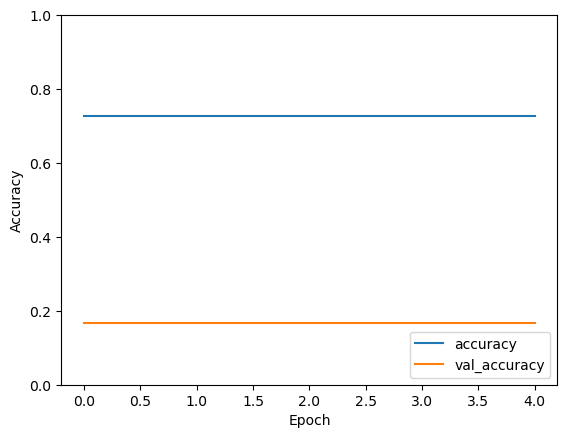

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()